<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/max/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
# Обработка обучащих данных
word_threshold = 32
text_to_analyze = ' '.join(dataset['train']['text'])

sentences = sent_tokenize(text_to_analyze)

train_sentences = [sentence for sentence in sentences if len(word_tokenize(sentence)) <= word_threshold]

# Обработка тестовых данных
text_to_analyze = ' '.join(dataset['test']['text'])

sentences = sent_tokenize(text_to_analyze)

test_sentences = [sentence for sentence in sentences if len(word_tokenize(sentence)) <= word_threshold]

In [7]:
sentences = train_sentences + test_sentences

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 392461


Посчитаем для каждого слова его встречаемость.

In [9]:
all_words = [word for sentence in sentences for word in word_tokenize(sentence)]
print("Всего слов:", len(all_words))

Всего слов: 6580350


In [10]:
# Расчет встречаемости слов
all_words.append('<unk>')
all_words.append('<bos>')
all_words.append('<eos>')
all_words.append('<pad>')

words_with_count = Counter(all_words)
len(words_with_count)

119305

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [11]:
# Наполнение словаря
vocab = set()
vocab_size = 40000

vocab = {word[0]: word[1] for i, word in enumerate(words_with_count.most_common(vocab_size))}


vocab['<unk>'] = 1
vocab['<bos>'] = 1
vocab['<eos>'] = 1
vocab['<pad>'] = 1

In [12]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [13]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


In [14]:
vocab['<pad>']

1

### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [15]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [17]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [18]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [19]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [20]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = logits = model(batch['input_ids'].cuda()).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [21]:
def train_model(model, num_epoch):
    # Напишите код здесьnum_epoch = 10
    losses = []
    perplexitys = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].cuda()).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        loss_value = sum(epoch_losses) / len(epoch_losses)
        perplexity = (evaluate(model, criterion, eval_dataloader))
        print(f"Epoch {epoch}: Loss={loss_value}, perplexity={perplexity}\n")
        
        losses.append(loss_value)
        perplexitys.append(perplexity)
        
    return model, losses, perplexitys

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [22]:
# Базовая модель с семинара
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [23]:
model, losses, perplexities = train_model(model, 10)

Training epoch 0::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 0: Loss=5.120706920763739, perplexity=115.00417047059497



Training epoch 1::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 1: Loss=4.6075809897085716, perplexity=99.19717205929834



Training epoch 2::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 2: Loss=4.434151334758686, perplexity=94.06787641195987



Training epoch 3::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 3: Loss=4.321459567357315, perplexity=92.55506951645842



Training epoch 4::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 4: Loss=4.236434844577259, perplexity=92.7845577525782



Training epoch 5::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 5: Loss=4.167602049881616, perplexity=94.12106290935306



Training epoch 6::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 6: Loss=4.110046192329366, perplexity=96.00199892621863



Training epoch 7::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 7: Loss=4.060582271654461, perplexity=98.35149410881515



Training epoch 8::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 8: Loss=4.017191446026733, perplexity=100.51344868414566



Training epoch 9::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 9: Loss=3.978652472890643, perplexity=102.75776659937557



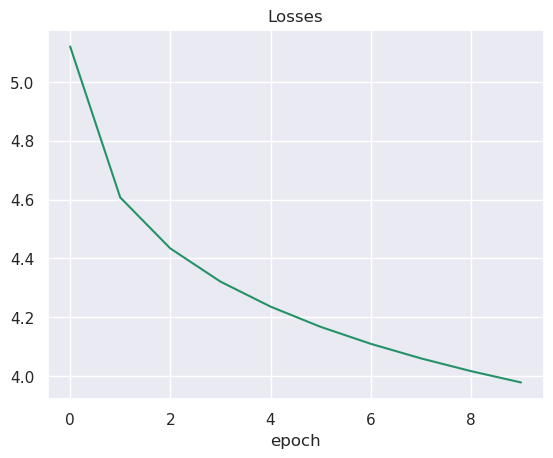

In [24]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

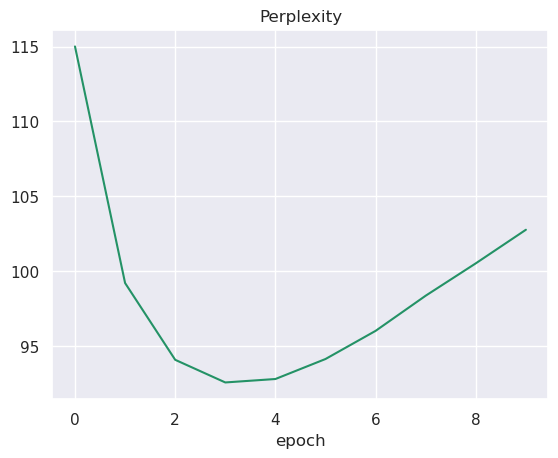

In [25]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [26]:
def generate_sentence(model, initial_words, max_length=50):
    device = 'cpu'
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        input_ids = [word2ind.get(word, word2ind['<unk>']) for word in initial_words]
        input_tensor = torch.LongTensor(input_ids).unsqueeze(0).to(device)

        output_ids = input_ids

        for _ in range(max_length):
            logits = model(input_tensor.to(device)).squeeze(0)[-1]
            predicted_id = torch.argmax(logits).item()
            # print(predicted_id)
            if predicted_id == word2ind['<eos>']:
                break

            output_ids.append(predicted_id)
            input_tensor = torch.cat([input_tensor, torch.LongTensor([[predicted_id]]).to(device)], dim=-1)

        generated_sentence = ' '.join([ind2word.get(idx, '<unk>') for idx in output_ids[1:]])
        return generated_sentence


In [27]:
initial_words = ['<bos>', 'this', 'film', 'is', 'so']
generated_sentence = generate_sentence(model, initial_words)
print("Generated Sentence:", generated_sentence)

Generated Sentence: this film is so bad that it 's not a good movie .


In [28]:
initial_words = ['<bos>', 'i', 'dont']
generated_sentence = generate_sentence(model, initial_words)
print("Generated Sentence:", generated_sentence)

Generated Sentence: i dont know what to say about this movie .


### Второй эксперимент (2 балла)

Изменим GRU слой на LSTM, добавим 2 сло

In [29]:
def train_model(model, num_epoch):
    # Напишите код здесьnum_epoch = 10
    losses = []
    perplexitys = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].cuda()).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        loss_value = sum(epoch_losses) / len(epoch_losses)
        perplexity = (evaluate(model, criterion, eval_dataloader))
        print(f"Epoch {epoch}: Loss={loss_value}, perplexity={perplexity}\n")
        
        losses.append(loss_value)
        perplexitys.append(perplexity)

        if epoch % 3 == 0 and epoch != 0:
            scheduler.step()
        
    return model, losses, perplexitys

In [40]:
from torch.optim.lr_scheduler import ExponentialLR
# Базовая модель с семинара
class BigLanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

model = BigLanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.1)

In [41]:
model, losses, perplexities = train_model(model, 10)

Training epoch 0::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 0: Loss=5.188297350844995, perplexity=110.33959548403463



Training epoch 1::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 1: Loss=4.525141913114253, perplexity=89.11775242311559



Training epoch 2::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 2: Loss=4.295112487786748, perplexity=83.16336340391675



Training epoch 3::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 3: Loss=4.1329978096499715, perplexity=81.76748960414228



Training epoch 4::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 4: Loss=3.9098478283048212, perplexity=78.32206180584936



Training epoch 5::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 5: Loss=3.8629117798328982, perplexity=77.91895270580578



Training epoch 6::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 6: Loss=3.834623860088213, perplexity=77.92978758920675



Training epoch 7::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 7: Loss=3.801389563681396, perplexity=77.36453464520483



Training epoch 8::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 8: Loss=3.794339448444415, perplexity=77.2483049448616



Training epoch 9::   0%|          | 0/2453 [00:00<?, ?it/s]

Epoch 9: Loss=3.791177488860431, perplexity=77.22160433790971



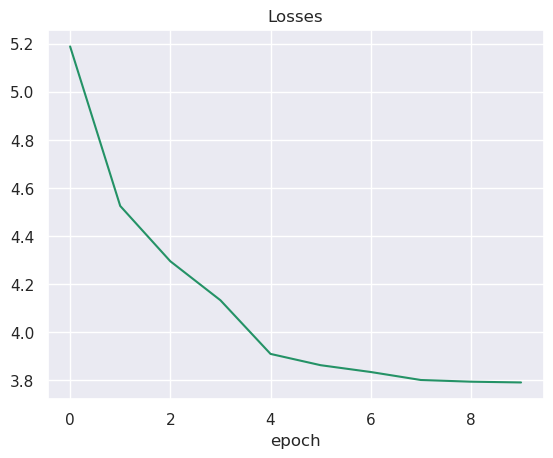

In [42]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

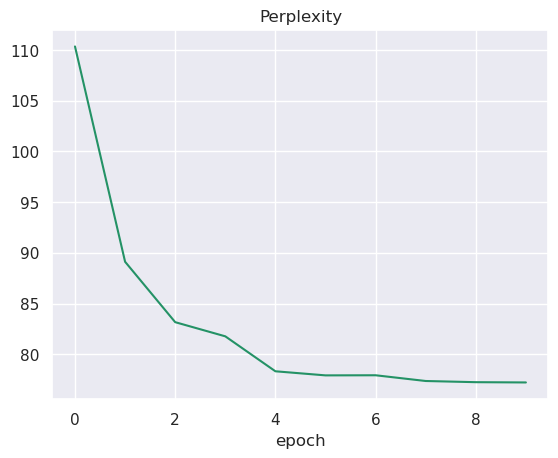

In [43]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [44]:
initial_words = ['<bos>', 'this', 'film', 'is', 'so']
generated_sentence = generate_sentence(model, initial_words)
print("Generated Sentence:", generated_sentence)

Generated Sentence: this film is so bad it 's funny .


In [45]:
initial_words = ['<bos>', 'i', 'dont']
generated_sentence = generate_sentence(model, initial_words)
print("Generated Sentence:", generated_sentence)

Generated Sentence: i dont know what I 'm saying , but I do n't think I 've ever seen a movie that is so bad .


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Сравнивая две модели, можно сказать следующее:
1) Увеличение слоев RNN уменьшает перплексию
2) Увеличение размерности скрытого пространства также уменьшает перплексию
3) Увеличение количества эпох не сильно влияет на перплексию модели, может возникануть обратная ситуация, когда происходит переобучение модели

Чтобы модель улучшила свои показатели, возможно, стоит поработать с словарем и сделать более умную предобработку данных.